# Setup Notebook

In [1]:
# When working in AI LRZ
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%run analysis_setup_cp.ipynb

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2
The data has N = 400 rows and N = 13 columns.


## Prepare Data


In [ ]:
# Filter out a single configuration to keep data manageable
#df_agg = df_agg_full[
#  (df_agg_full["sett_eval_fairness_grouping"] == "nationality-all") #&
#  #(df_agg_full["sett_eval_exclude_subgroups"] == "keep-in-eval") &
#  #(df_agg_full["sett_eval_on_subset"] == "full")
#][
#  # Remove eval columns
#  cols_non_eval + cols_performance + cols_fairness
#].reset_index(drop = True)
#
#df_agg.shape

In [3]:
import pandas as pd
from pathlib import Path

RUN_TO_ANALYSE = "11"
CP_DIR = Path("output") / "runs" / str(RUN_TO_ANALYSE)

df_agg = pd.read_csv(CP_DIR / "combined_cp_metrics.csv")

In [4]:
df_agg.head()

,universe_id,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups,q_hat,coverage,avg_size,cov_frau1,cov_nongerman,cov_nongerman_male,cov_nongerman_female
0,45b5af5bcdf492568192aee3a41b8cef,2014,scale,elasticnet,nationality,keep-all,0.672680,0.912351,1.120466,0.911794,0.910459,0.925786,0.885097
1,f8c2c45aee819eb65a8eb952f29a48a2,5k,do-not-scale,penalized_logreg,none,drop-non-german,0.672460,0.912919,1.221514,0.913438,0.942402,0.951545,0.927273
2,00d9e56309d2fd3c40c0df59c658f0d9,5k,scale,elasticnet,sex,drop-non-german,0.683588,0.910746,1.146862,0.909449,0.912873,0.927047,0.889419
3,43877f96ae422c48dc9f8ea86e07942f,2014,do-not-scale,penalized_logreg,none,keep-all,0.675828,0.911637,1.195965,0.910446,0.927918,0.941818,0.904918
4,2412acc942f945b749d843a93283b568,2014,scale,gbm,nationality-sex,keep-all,0.661087,0.910679,1.108249,0.912360,0.908831,0.923264,0.884948


In [5]:
df_agg.shape

(400, 13)

In [6]:
main_cp_metric = "avg_size" # "avg_size", "cov_nongerman_female"

In [ ]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#
## Plot distribution of q_hat
#plt.figure(figsize=(8, 5))
#sns.histplot(df_agg["q_hat"], bins=10, kde=True, color="skyblue")
#plt.title("Distribution of q_hat Values")
#plt.xlabel("q_hat")
#plt.ylabel("Frequency")
#plt.grid(True)
#plt.tight_layout()
#plt.show()

# Calculate Variable Importance

## Use a Lasso Regression to estimate Importance of Settings

In [7]:
X = df_agg[["universe_training_size", "universe_scale", "universe_model", "universe_exclude_features", "universe_exclude_subgroups"]]
y = df_agg[main_cp_metric]

In [8]:
X.head()

,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups
0,2014,scale,elasticnet,nationality,keep-all
1,5k,do-not-scale,penalized_logreg,none,drop-non-german
2,5k,scale,elasticnet,sex,drop-non-german
3,2014,do-not-scale,penalized_logreg,none,keep-all
4,2014,scale,gbm,nationality-sex,keep-all


In [9]:
X.shape

(400, 5)

In [10]:
y.shape

(400,)

### Main Effects of Settings Only (i.e. no interactions)

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV

# Do preprocessing in a separate pipeline from model fitting
# (for eli5 to work)
preprocessor = make_pipeline(
    OneHotEncoder(), # Converts categorical features to one-hot encoded format
).fit(X) # Fit the preprocessing pipeline to the input data X
X_processed = preprocessor.transform(X) # This creates a numeric matrix suitable for modeling

# Fit a Lasso regression model with cross-validation to the processed data
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.6824309249269963

R² = 1.0: Perfect predictions

R² = 0.0: Model does no better than predicting the mean

R² < 0.0: Model is worse than just predicting the mean

Weights of importance:

In [12]:
# Visualize the importance of each feature in trained lasso_reg model
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+1.135,<BIAS>
+0.055,universe_training_size_1k
+0.030,universe_scale_do-not-scale
+0.021,universe_model_penalized_logreg
+0.021,universe_model_logreg
+0.019,universe_exclude_features_age
+0.007,universe_training_size_5k
+0.004,universe_exclude_subgroups_drop-non-german
-0.000,universe_exclude_subgroups_keep-all
-0.000,universe_scale_scale


### Including Interactions

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV

# Do preprocessing w/o a pipeline for eli5 to work
preprocessor = make_pipeline(
    OneHotEncoder(),
    PolynomialFeatures(degree=2),
).fit(X)
X_processed = preprocessor.transform(X)

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.9231065494668595

Weights of importance:

In [14]:
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+1.144,<BIAS>
+0.047,universe_scale_do-not-scale universe_model_penalized_logreg
+0.047,universe_scale_do-not-scale universe_model_logreg
+0.044,universe_training_size_1k
+0.032,universe_scale_do-not-scale universe_exclude_features_age
+0.024,universe_training_size_1k universe_scale_scale
+0.022,universe_training_size_1k universe_model_elasticnet
+0.020,universe_model_elasticnet universe_exclude_features_age
+0.008,universe_scale_do-not-scale universe_exclude_subgroups_drop-non-german
+0.007,universe_scale_scale universe_model_rf


## Use a functinoal ANOVA (fANOVA) to Analyze Setting Importance

Based on the following paper:

Hutter, F., Hoos, H., & Leyton-Brown, K. (2014). An Efficient Approach for Assessing Hyperparameter Importance. Proceedings of the 31st International Conference on Machine Learning, 754–762. https://proceedings.mlr.press/v32/hutter14.html


In [17]:
from fairness_multiverse.analysis import MultiverseFanova

m_fanova = MultiverseFanova(features = df_agg[["universe_training_size", "universe_model", "universe_exclude_features", "universe_exclude_subgroups", "universe_scale"]], outcome = df_agg[main_cp_metric])


In [18]:
m_fanova.quantify_individual_importance()

,individual importance,total importance,individual std,total std
universe_exclude_features,0.027726,0.027726,0.005534,0.005534
universe_exclude_subgroups,0.002635,0.002635,0.001477,0.001477
universe_model,0.199311,0.199311,0.009147,0.009147
universe_scale,0.117302,0.117302,0.007189,0.007189
universe_training_size,0.329922,0.329922,0.020443,0.020443


In [32]:
m_fanova.quantify_importance(save_to = CP_DIR/ "fanova_importance_interactions-overall_alpha_2.csv")

,level_0,level_1,level_2,level_3,level_4,individual importance,total importance,individual std,total std
4,universe_training_size,NaN,NaN,NaN,NaN,0.329922,0.329922,0.020443,2.044317e-02
2,universe_model,NaN,NaN,NaN,NaN,0.199311,0.199311,0.009147,9.146866e-03
3,universe_scale,NaN,NaN,NaN,NaN,0.117302,0.117302,0.007189,7.189044e-03
12,universe_model,universe_scale,NaN,NaN,NaN,0.095013,0.411627,0.005851,1.046726e-02
13,universe_model,universe_training_size,NaN,NaN,NaN,0.072806,0.602039,0.015174,3.050697e-02
24,universe_model,universe_scale,universe_training_size,NaN,NaN,0.037389,0.878842,0.005135,3.706247e-02
0,universe_exclude_features,NaN,NaN,NaN,NaN,0.027726,0.027726,0.005534,5.534289e-03
14,universe_scale,universe_training_size,NaN,NaN,NaN,0.027099,0.474322,0.003958,2.248620e-02
7,universe_exclude_features,universe_scale,NaN,NaN,NaN,0.019519,0.164547,0.004302,1.471586e-02
6,universe_exclude_features,universe_model,NaN,NaN,NaN,0.015796,0.242834,0.008479,1.405267e-02


In [37]:
import os

# Latex table
fanova_df = m_fanova.quantify_importance()

# Format all float columns to 4 decimal places
formatted_df = fanova_df.copy()
float_cols = ['individual importance', 'total importance', 'individual std', 'total std']
formatted_df[float_cols] = formatted_df[float_cols].applymap(lambda x: f"{x:.4f}")

# Replace NaN with empty string for cleaner LaTeX output
formatted_df = formatted_df.fillna('')

# Convert to LaTeX table
latex_table = formatted_df.to_latex(
    index=False,
    escape=True,  # Escapes underscores and special characters
    column_format='llllrrrr',
    caption='fANOVA Importance and Interaction Effects',
    label='tab:fanova_importance'
)

# Save to file inside CP_DIR
output_path = os.path.join(CP_DIR, "fanova_importance_table.tex")
with open(output_path, "w") as f:
    f.write(latex_table)

TypeError: Styler.to_latex() got an unexpected keyword argument 'escape'

In [20]:
# Format

cols_to_format = [
    "individual importance",
    "total importance",
    "individual std",
    "total std"
]

fanova_interactions = m_fanova.quantify_importance()
fanova_interactions[cols_to_format] = fanova_interactions[cols_to_format].applymap(lambda x: f"{x:.4f}")
fanova_interactions

,level_0,level_1,level_2,level_3,level_4,individual importance,total importance,individual std,total std
4,universe_training_size,NaN,NaN,NaN,NaN,0.3299,0.3299,0.0204,0.0204
2,universe_model,NaN,NaN,NaN,NaN,0.1993,0.1993,0.0091,0.0091
3,universe_scale,NaN,NaN,NaN,NaN,0.1173,0.1173,0.0072,0.0072
12,universe_model,universe_scale,NaN,NaN,NaN,0.0950,0.4116,0.0059,0.0105
13,universe_model,universe_training_size,NaN,NaN,NaN,0.0728,0.6020,0.0152,0.0305
24,universe_model,universe_scale,universe_training_size,NaN,NaN,0.0374,0.8788,0.0051,0.0371
0,universe_exclude_features,NaN,NaN,NaN,NaN,0.0277,0.0277,0.0055,0.0055
14,universe_scale,universe_training_size,NaN,NaN,NaN,0.0271,0.4743,0.0040,0.0225
7,universe_exclude_features,universe_scale,NaN,NaN,NaN,0.0195,0.1645,0.0043,0.0147
6,universe_exclude_features,universe_model,NaN,NaN,NaN,0.0158,0.2428,0.0085,0.0141


In [21]:
best_p_margs = m_fanova.fanova.get_most_important_pairwise_marginals(n=5)
print(best_p_margs)

OrderedDict([(('universe_model', 'universe_scale'), 0.0950134213650542), (('universe_model', 'universe_training_size'), 0.07280620695740751), (('universe_scale', 'universe_training_size'), 0.027098662194737496), (('universe_exclude_features', 'universe_scale'), 0.01951889813867576), (('universe_exclude_features', 'universe_model'), 0.015795692940304508)])


In [22]:
# Directory that will contain outputs from analysis

from pathlib import Path

ANALYSIS_OUTPUT_DIR = Path(".") / "analyses"
ANALYSIS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [23]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(ANALYSIS_OUTPUT_DIR))

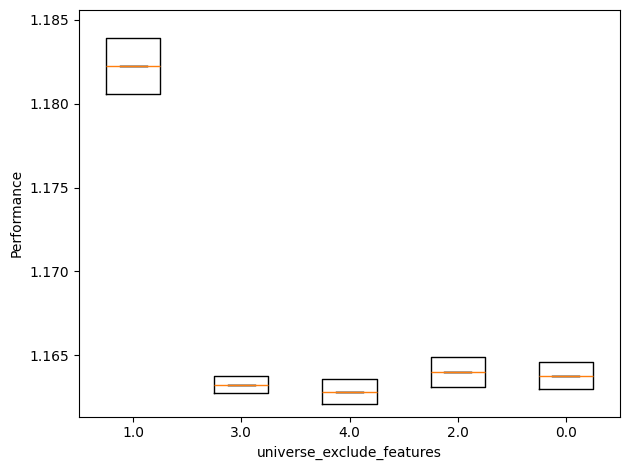

In [24]:
vis.plot_marginal(0)

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

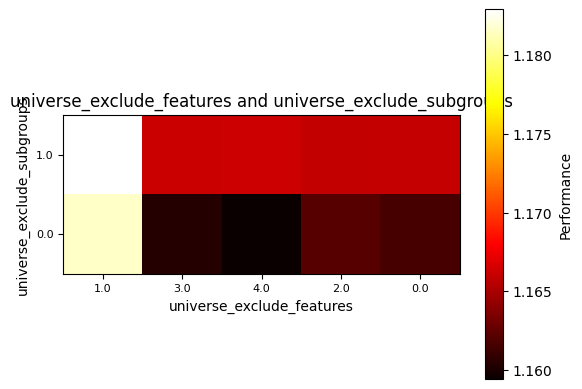

In [25]:
vis.plot_pairwise_marginal(['universe_exclude_features', 'universe_exclude_subgroups'])

## Quantify Importance with Partial Data

In [26]:
from tqdm import tqdm

PARTIAL_FANOVA_DIR = ANALYSIS_OUTPUT_DIR / "partial_fanova" / "overall"
PARTIAL_FANOVA_DIR.mkdir(parents=True, exist_ok=True)

N_ITERATIONS = 10

In [27]:
from fairness_multiverse.analysis import MultiverseFanova
import joblib

def quantify_importance_for_fraction(fraction: float, base_directory = PARTIAL_FANOVA_DIR):
    # Get random subset of the data
    df = df_agg.sample(frac = fraction).reset_index(drop = True)
    data_hash = joblib.hash(df)

    # Create directory for this fraction
    directory = base_directory / f"fraction-{fraction}"
    directory.mkdir(exist_ok = True)

    # Run FANOVA on subset
    partial_fanova = MultiverseFanova(features = df[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df[main_cp_metric])
    partial_fanova.quantify_importance(save_to = directory / f"partial-fanova_importance_interactions-majmin-{fraction}-{data_hash}.csv")

In [28]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.01)

100%|██████████| 10/10 [00:00<00:00, 45.86it/s]


In [29]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.05)

100%|██████████| 10/10 [00:00<00:00, 21.34it/s]


In [30]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.1)

100%|██████████| 10/10 [00:00<00:00, 19.35it/s]


In [31]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.2)

100%|██████████| 10/10 [00:00<00:00, 19.00it/s]
